In [1]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
import numpy as np

from sklearn.metrics import roc_auc_score, average_precision_score

%matplotlib inline
import matplotlib.pyplot as plt
from latent.utils import draw_samples_2d

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.ToDevice('cuda')])

dataset = Planetoid("data/", "CiteSeer", transform=transform)

split = T.RandomLinkSplit(0.05, 0.1, is_undirected=True)
train_data, val_data, test_data = split(dataset[0])
train_data.edge_label = train_data.edge_label_index = None

train_data, val_data, test_data

/home/anthony/.local/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


(Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327]),
 Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[454], edge_label_index=[2, 454]),
 Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[910], edge_label_index=[2, 910]))

In [3]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

    # def forward(self, z, edge_index):
    #     result = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
    #     return torch.sigmoid(result)

    def forward(self, z, edge_index):
        diff = z[edge_index[0]] - z[edge_index[1]]
        norm = torch.norm(diff, dim=1)

        return 1 / (1 + norm)

    def forward_all(self, z):
        adj = torch.matmul(z, z.t())
        adj = torch.sigmoid(adj)

        return adj

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(1, num_layers-1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i in range(self.num_layers-1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)

        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)

        return mu, logstd


class VGAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                       num_layers, lambda1, lambda2):
        super().__init__()

        self.lambda1 = 2 * lambda1 / (lambda1 + lambda2)
        self.lambda2 = 2 * lambda2 / (lambda1 + lambda2)

        self.encoder = Encoder(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            num_layers=num_layers
        )
        self.decoder = Decoder()
        self.bce_loss = torch.nn.BCELoss(reduction='mean')

    def recon_loss(self, y_pred, y_true):
        return self.lambda1 * self.bce_loss(y_pred, y_true).mean()

    def dkl_loss(self, mu, logstd):
        return self.lambda2 * -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        z = self.reparametrize(mu, logstd)

        return z, mu, logstd

    def decode(self, z, edge_index=None):
        if edge_index is not None:
            return self.decoder(z, edge_index)
        
        return self.decoder.forward_all(z)


In [4]:
num_features = dataset.data.num_features

device = torch.device('cuda')
vgae = VGAE(
    in_channels=num_features,
    hidden_channels=32,
    out_channels=2,
    num_layers=2,
    lambda1=8.0,
    lambda2=1.0
)
vgae = vgae.to(device)
optimizer = torch.optim.Adam(vgae.parameters(), lr=0.01)

vgae

VGAE(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): GCNConv(3703, 32)
    )
    (conv_mu): GCNConv(32, 2)
    (conv_logstd): GCNConv(32, 2)
  )
  (decoder): Decoder()
  (bce_loss): BCELoss()
)

In [5]:
def train(model, train_data):
    model.train()
    optimizer.zero_grad()

    z, mu, logstd = model.encode(train_data.x, train_data.edge_index)
    y_pred = model.decode(z, train_data.edge_label_index)
    
    recon_loss = model.recon_loss(y_pred, train_data.edge_label)
    dkl_loss = model.dkl_loss(mu, logstd)
    loss = recon_loss + dkl_loss

    loss.backward()
    optimizer.step()

    return float(loss), float(recon_loss), float(dkl_loss)

@torch.no_grad()
def test(model, val_data):
    model.eval()

    z, _, _ = model.encode(val_data.x, val_data.edge_index)
    y_pred = model.decode(z, val_data.edge_label_index)
    
    y_true, y_pred = val_data.edge_label.cpu().numpy(), y_pred.cpu().numpy()

    return roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred)

In [6]:
num_epochs = 1000
split = T.RandomLinkSplit(0.15, 0.0, is_undirected=True)

for epoch in range(num_epochs):
    train_split, _, _ = split(train_data)

    train_loss = train(vgae, train_split)
    roc_auc, ap = test(vgae, val_data)

    if epoch % 10 == 0:
        print('Epoch {:04d}: train_loss: ({:.4f}; {:.4f}; {:.4f}); ROC_AUC: {:.4f}; AP: {:.4f}'
                .format(epoch, *train_loss, roc_auc, ap))

Epoch 0000: train_loss: (1.3459; 1.3459; 0.0000); ROC_AUC: 0.5980; AP: 0.6283
Epoch 0010: train_loss: (1.3139; 1.2954; 0.0184); ROC_AUC: 0.5574; AP: 0.5809
Epoch 0020: train_loss: (1.3248; 1.3115; 0.0133); ROC_AUC: 0.6365; AP: 0.6282
Epoch 0030: train_loss: (1.2856; 1.2680; 0.0176); ROC_AUC: 0.6875; AP: 0.7016
Epoch 0040: train_loss: (1.2568; 1.2291; 0.0277); ROC_AUC: 0.6952; AP: 0.7127
Epoch 0050: train_loss: (1.2557; 1.2152; 0.0405); ROC_AUC: 0.6861; AP: 0.6922
Epoch 0060: train_loss: (1.2370; 1.1805; 0.0565); ROC_AUC: 0.6991; AP: 0.6955
Epoch 0070: train_loss: (1.2277; 1.1624; 0.0653); ROC_AUC: 0.6933; AP: 0.7172
Epoch 0080: train_loss: (1.2158; 1.1446; 0.0712); ROC_AUC: 0.6907; AP: 0.7047
Epoch 0090: train_loss: (1.2284; 1.1530; 0.0754); ROC_AUC: 0.7009; AP: 0.7238
Epoch 0100: train_loss: (1.2174; 1.1361; 0.0812); ROC_AUC: 0.6934; AP: 0.7196
Epoch 0110: train_loss: (1.2158; 1.1332; 0.0825); ROC_AUC: 0.6763; AP: 0.6854
Epoch 0120: train_loss: (1.2122; 1.1323; 0.0799); ROC_AUC: 0.670

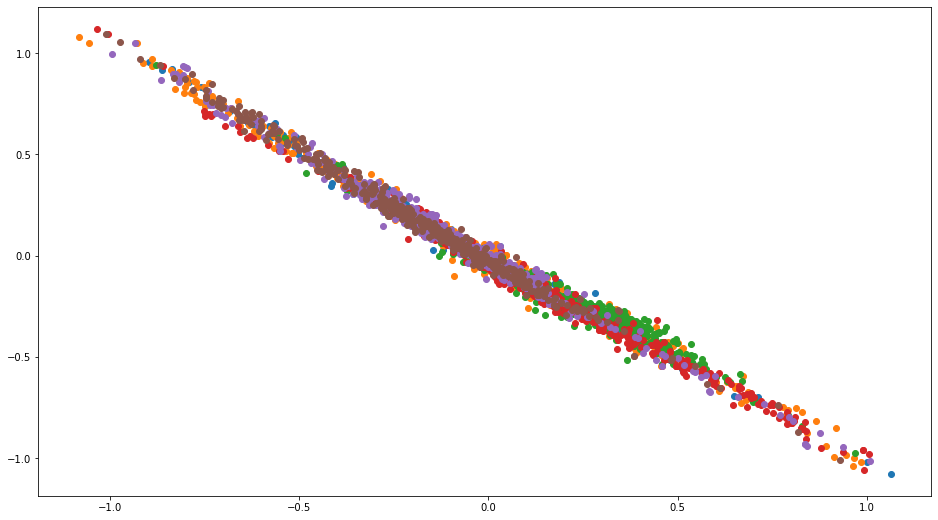

In [7]:
with torch.no_grad():
    z, _, _ = vgae.encode(test_data.x, test_data.edge_index)

draw_samples_2d(z.cpu().numpy(), test_data.y.cpu().numpy())

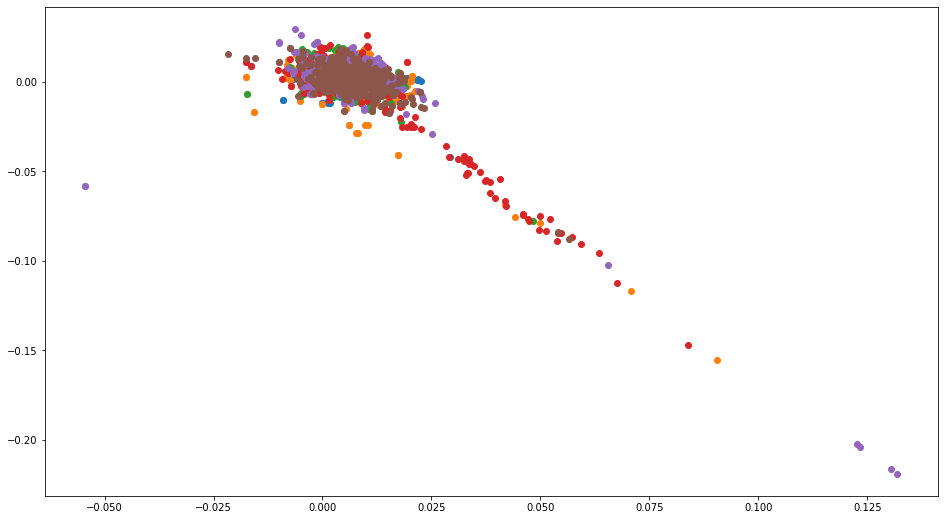

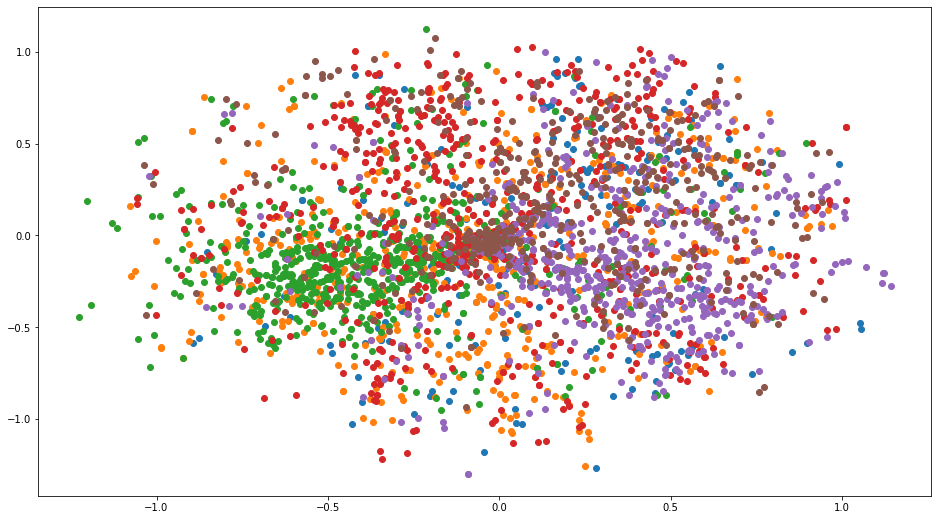

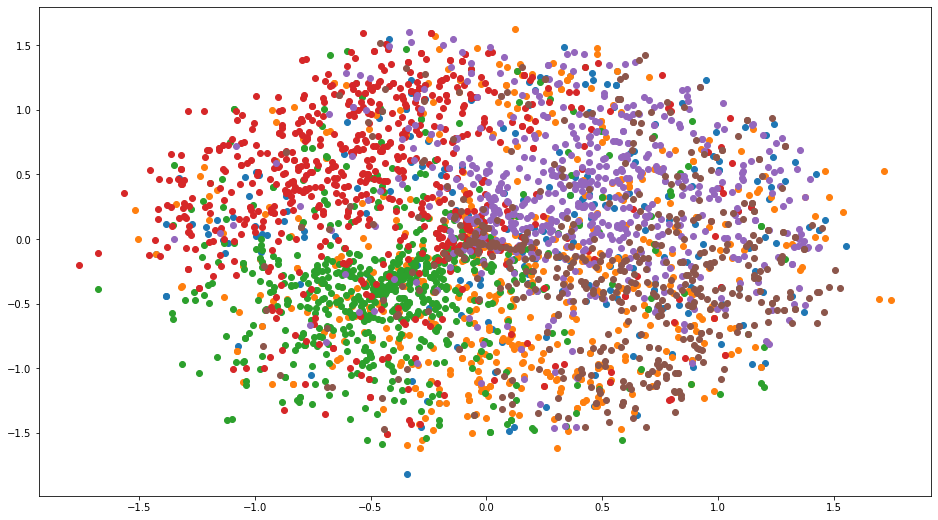

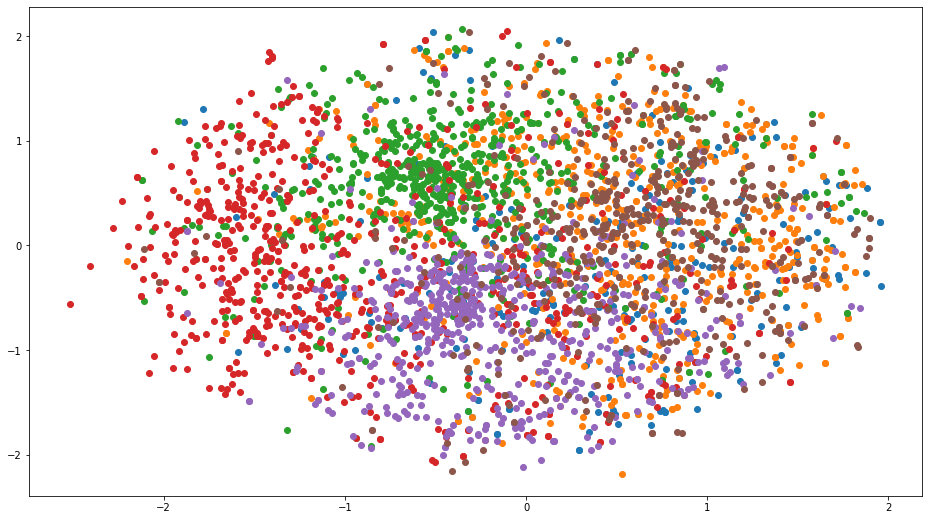

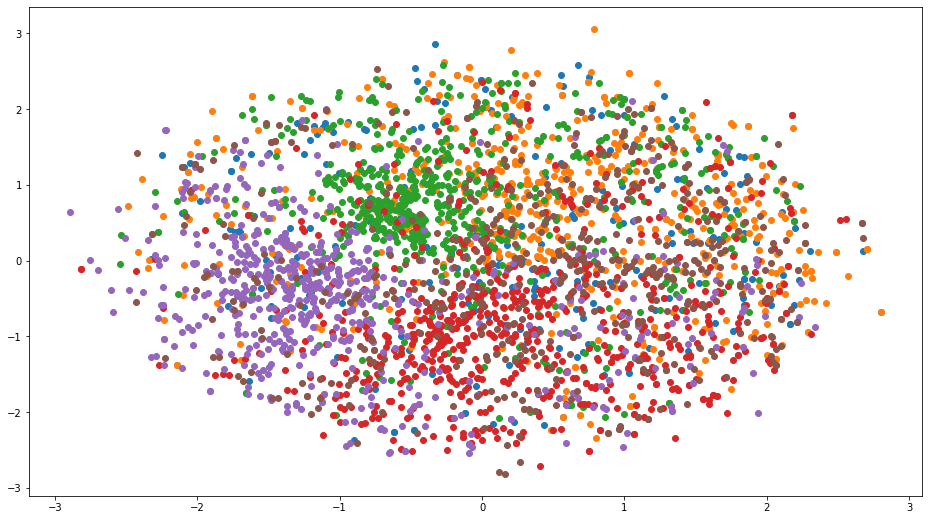

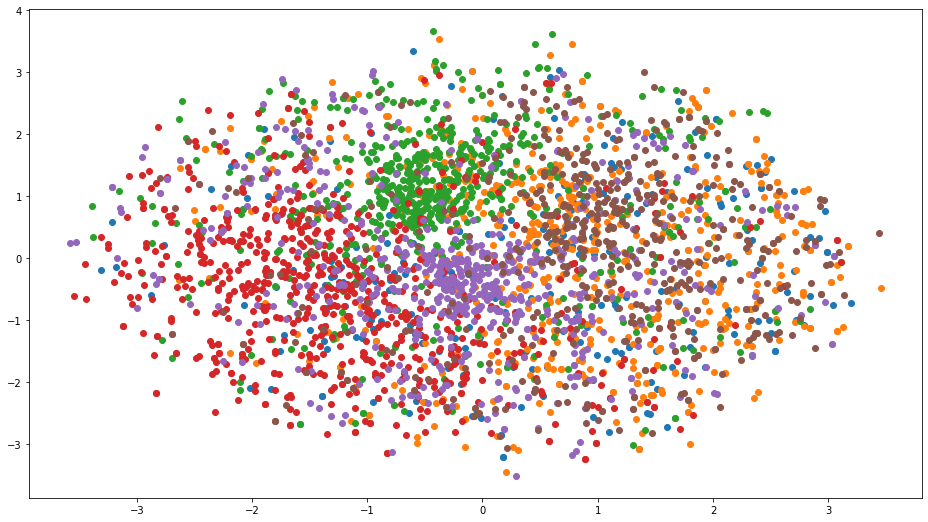

/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [0,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [1,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [2,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [3,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [4,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [5,0,0] Assertion `input_val >= zero && input_val <= one` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:111: operator(): block: [19,0,0], thread: [6,0,0] A

RuntimeError: transform: failed to synchronize: cudaErrorAssert: device-side assert triggered

In [8]:
# roc_auc_l = []
# ap_l = []
# dkl_l = []

# for i in range(-1, 13):
#     mdl = VGAE(
#         in_channels=num_features,
#         hidden_channels=32,
#         out_channels=2,
#         num_layers=2,
#         lambda1=2**i,
#         lambda2=1.0
#     )
#     mdl = mdl.to(device)
#     optimizer = torch.optim.Adam(mdl.parameters(), lr=0.01)

#     for epoch in range(1000):
#         train_split, _, _ = split(train_data)
#         train_loss = train(mdl, train_split)

#     roc_auc, ap = test(mdl, val_data)
#     roc_auc_l.append(roc_auc)
#     ap_l.append(ap)
#     dkl_l.append(train_loss[-1] / mdl.lambda2)

#     with torch.no_grad():
#         z, _, _ = mdl.encode(test_data.x, test_data.edge_index)

#     draw_samples_2d(z.cpu().numpy(), test_data.y.cpu().numpy())
#     plt.show()

In [9]:
# dkl = np.array(dkl_l)
# dkl = dkl - dkl.min()
# dkl = dkl / dkl.max()
# plt.plot(np.arange(14), roc_auc_l, label='roc_auc')
# plt.plot(np.arange(14), ap_l, label='ap')
# plt.plot(np.arange(14), dkl, label='dkl')
# plt.legend()